In [22]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as td
import torchvision
import os
import random
import shutil

import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import math
import torchvision.models as models
import pandas as pd
from torchvision.transforms import v2

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
from torchvision import datasets, transforms, models
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.transforms import v2

In [3]:
csv_file_path = "/kaggle/input/data/Data_Entry_2017.csv"
df = pd.read_csv(csv_file_path, usecols=[0, 1], index_col = None)
print(df)
def find_lable(file_name):
    resulted_df = df[df.iloc[:, 0] == file_name]  # Assuming the file name is in the first column
    if not resulted_df.empty:
        return resulted_df.iloc[0, 1]  # Assuming the label is in the second column
    else:
        return "Label not found for file: {}".format(file_name)

             Image Index          Finding Labels
0       00000001_000.png            Cardiomegaly
1       00000001_001.png  Cardiomegaly|Emphysema
2       00000001_002.png   Cardiomegaly|Effusion
3       00000002_000.png              No Finding
4       00000003_000.png                  Hernia
...                  ...                     ...
112115  00030801_001.png          Mass|Pneumonia
112116  00030802_000.png              No Finding
112117  00030803_000.png              No Finding
112118  00030804_000.png              No Finding
112119  00030805_000.png              No Finding

[112120 rows x 2 columns]


In [4]:
def copy(src,dest,filename):
    os.makedirs(dest,exist_ok=True)
    input_path = os.path.join(src, filename)
    output_path = os.path.join(dest, filename)
    shutil.copyfile(input_path, output_path)

In [5]:
def processing():
    folders_to_loop = ["/kaggle/input/data/images_001/images","/kaggle/input/data/images_002/images", "/kaggle/input/data/images_002/images", "/kaggle/input/data/images_004/images"]
    os.makedirs("dataset", exist_ok = True)
    for i in folders_to_loop:
        for filename in os.listdir(i):
#             print(filename)
            lable = find_lable(filename)
            split_lables = lable.split('|')
            for x in split_lables:
                dest = "dataset/"+x
#                 print(dest)
                copy(i, dest, filename)
        
            
processing()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

freeze = False
dropout = True
prob = 0.3
lr = 0.001
momentum = 0.9
step_size = 20
gamma = 0.1
criterion_name = 'Focal'
optimizer_name = 'Adam'
num_classes = 2
num_epochs = 30
batch_size = 30

In [14]:
transform = v2.Compose([
    v2.Resize(256),   #must same as here
    v2.CenterCrop(224),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

path = "/kaggle/working/dataset"
dataset = torchvision.datasets.ImageFolder(root = path, transform = transform)
print(len(dataset))

30288


In [13]:
train_size = int(0.6 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [15]:
print('Train dataset size:', train_size)
print('Validate dataset size:', val_size)
print('Test dataset size:', test_size)
class_names = dataset.classes
print('Class names:', class_names)

Train dataset size: 18172
Validate dataset size: 4543
Test dataset size: 7573
Class names: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [15]:
train_count = len(train_data)
test_count = len(test_data)
val_count = len(val_data)
start_time = time.time()

labels tensor([10,  6, 10, 10, 10, 11, 10, 11, 14, 10, 10,  8])


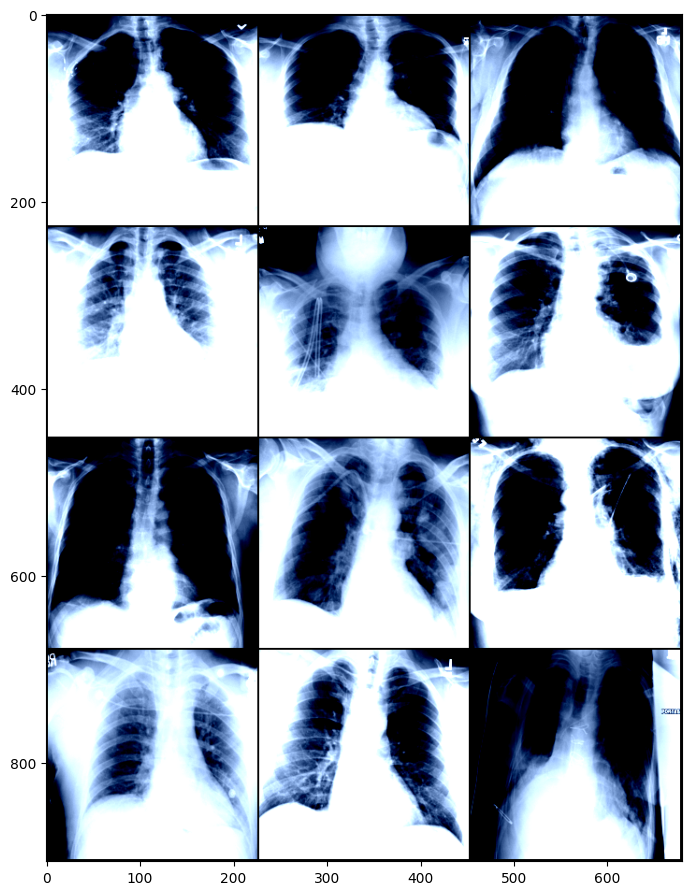

In [16]:

def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset,batch_size = 12,shuffle=True)
    batch = next(iter(loader))
    images,labels = batch

    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels',labels)

show_transformed_images(train_data)

In [17]:
model = models.resnet18(weights=None,num_classes=15)
model.eval()
for param in model.parameters():
    param.requires_grad = False

In [19]:
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

features_all = []
labels_all = []
with torch.no_grad():
    for loader in [train_loader, val_loader, test_loader]:
        print(loader)
        for images, batch_labels in loader:
            batch_features = feature_extractor(images)
            batch_features = torch.flatten(batch_features, start_dim=1)
            features_all.append(batch_features)
            labels_all.append(batch_labels)
features_all = torch.cat(features_all, dim=0)
labels_all = torch.cat(labels_all, dim=0)

In [23]:
distances_all = pairwise_distances(features_all.numpy())
sigma_all = torch.median(torch.tensor(distances_all)).item()
similarities_all = torch.exp(-torch.tensor(distances_all)**2 / (2 * sigma_all**2))

# Compute t-SNE embeddings
tsne_all = TSNE(n_components=2, perplexity=30, verbose=1)
embeddings_all = tsne_all.fit_transform(similarities_all.numpy())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30288 samples in 0.342s...
[t-SNE] Computed neighbors for 30288 samples in 591.906s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30288
[t-SNE] Computed conditional probabilities for sample 2000 / 30288
[t-SNE] Computed conditional probabilities for sample 3000 / 30288
[t-SNE] Computed conditional probabilities for sample 4000 / 30288
[t-SNE] Computed conditional probabilities for sample 5000 / 30288
[t-SNE] Computed conditional probabilities for sample 6000 / 30288
[t-SNE] Computed conditional probabilities for sample 7000 / 30288
[t-SNE] Computed conditional probabilities for sample 8000 / 30288
[t-SNE] Computed conditional probabilities for sample 9000 / 30288
[t-SNE] Computed conditional probabilities for sample 10000 / 30288
[t-SNE] Computed conditional probabilities for sample 11000 / 30288
[t-SNE] Computed conditional probabilities for sample 12000 / 30288
[t-SNE] Computed conditional probabilities for s

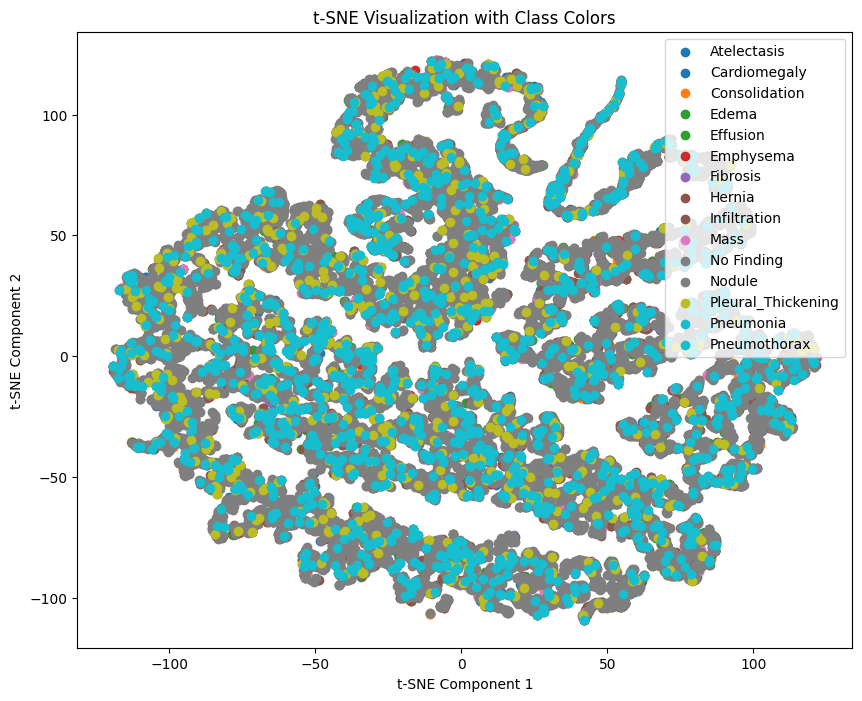

In [25]:
num_classes = len(np.unique(labels_all))
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Plot t-SNE embeddings with colors
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.scatter(embeddings_all[labels_all == i, 0], embeddings_all[labels_all == i, 1], color=colors[i], label=class_names[i])

plt.title('t-SNE Visualization with Class Colors')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

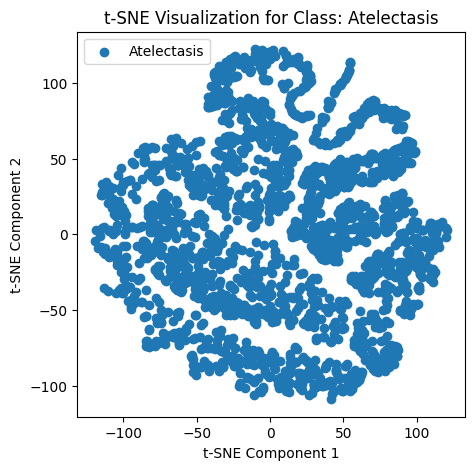

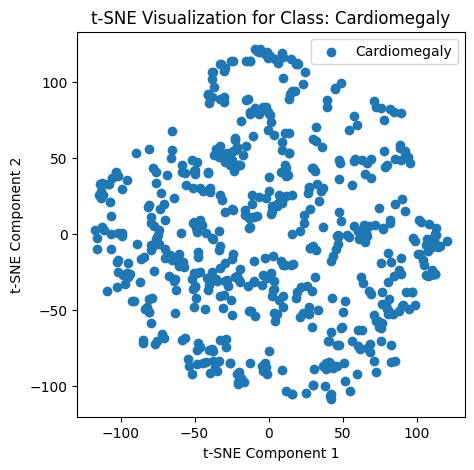

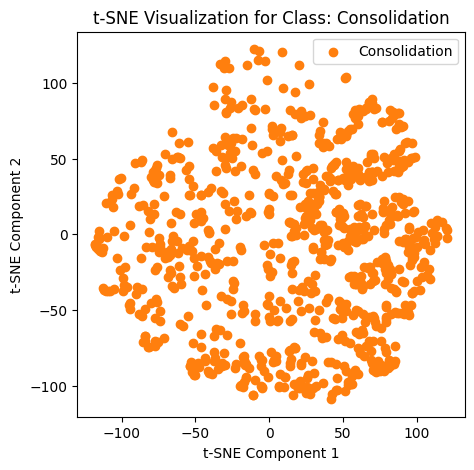

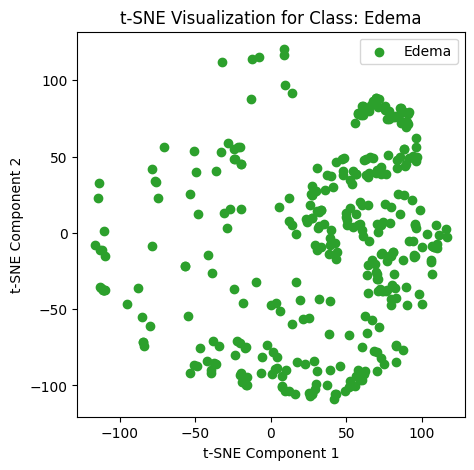

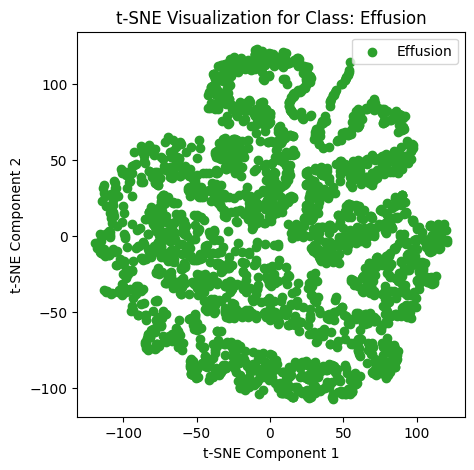

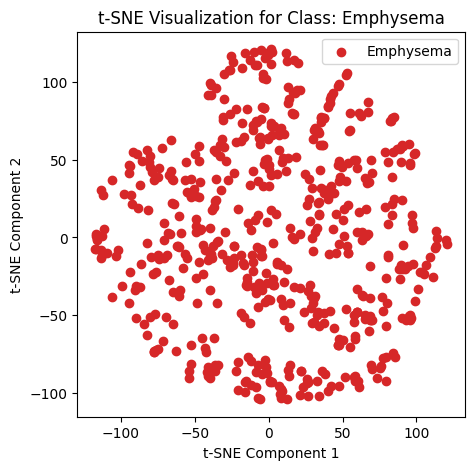

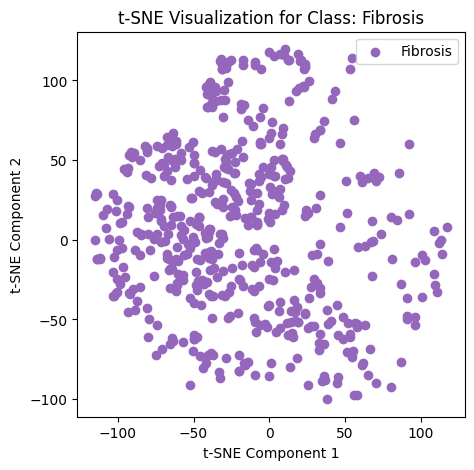

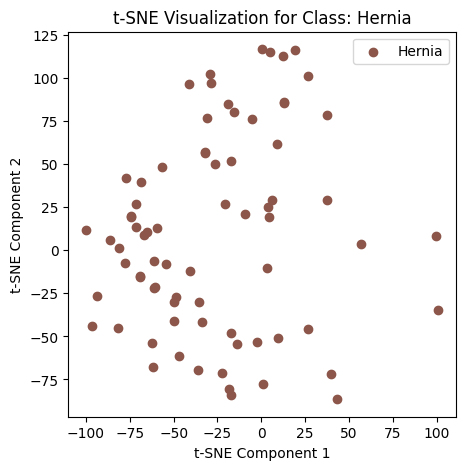

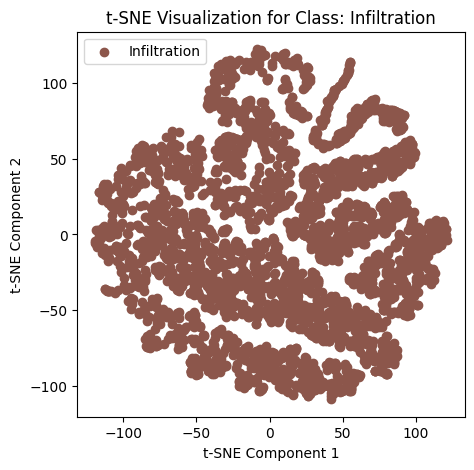

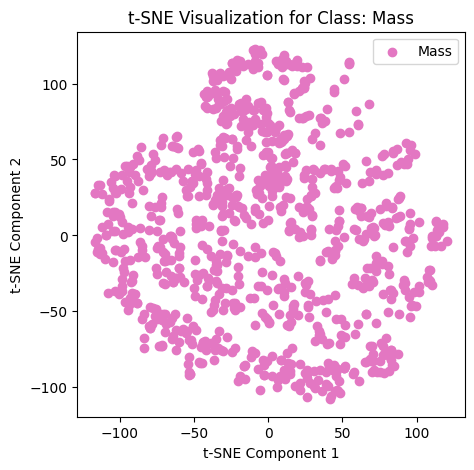

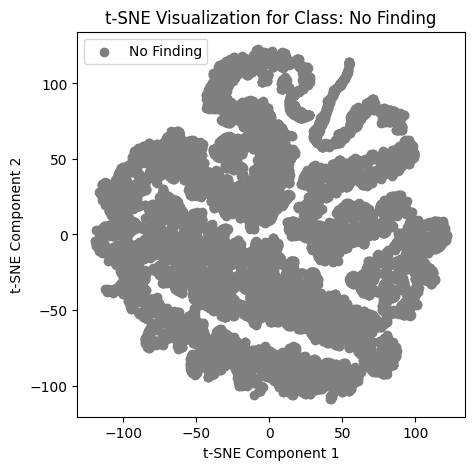

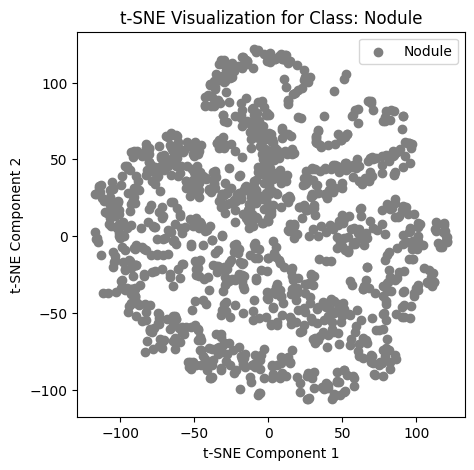

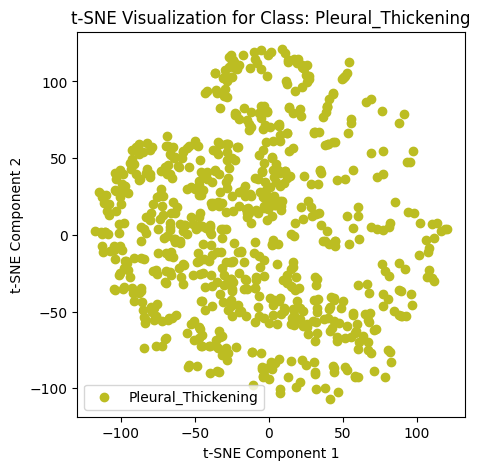

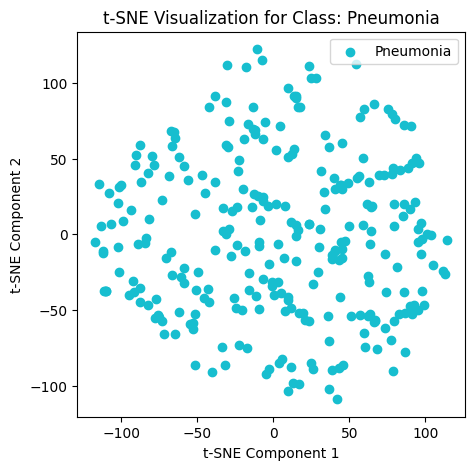

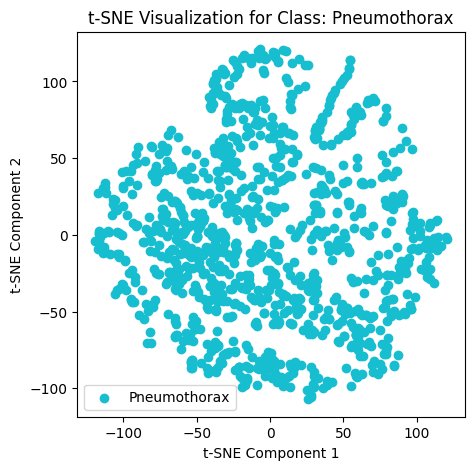

In [28]:
num_classes = len(class_names)
colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

# Create a separate plot for each class
for i in range(num_classes):
    # Select embeddings and labels for the current class
    class_embeddings = embeddings_all[labels_all == i]
    class_labels = labels_all[labels_all == i]

    # Plot t-SNE embeddings for the current class
    plt.figure(figsize=(5, 5))
    plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], color=colors[i], label=class_names[i])
    plt.title(f't-SNE Visualization for Class: {class_names[i]}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()